# Overview

The dataset in this analysis contains information on 97 albums that I have listened to in their entirety and for which I have consequently formed a strong opinion. Since I read a lot of album reviews, I was interested in understanding whether my album scores were correlated to album scores of several music publications — AllMusic, musicOMH, Pitchfork, The Guardian — and one aggregator website, Metacritic. I was also interested in finding out whether my album score could be predicted using information on album length, year of release, type of artist, and music genre.

Obviously, a significant drawback of this dataset stems from the fact that my system of evaluating album scores might be vastly different from that of music publications. I purposefully kept my method of scoring consistent across all albums using the following formula:

$
\begin{equation} 
album\:score = \frac{number\:of\:songs\:I\:like}{number\:of\:songs\:on\:the\:album}\cdot{100}
\end{equation}
$

There is no guarantee, of course, that music publications used the same method. And, it's naturally possible that, within the same music publication, scoring methodologies were inconsistent. 

I first explored the data by looking at basic descriptive and inferential statistics, and by visualizing the frequency distribution of scores across different categories and publishers. 

In [83]:
# LOADING THE DATA

# Importing required packages

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import t
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# Importing album data
colnames = ['artist_name', 'album_name', 'year', 'length', 'type', 'genre', 'female', 
            'pop', 'electronic', 'experimental', 'rock', 
            'my_score', 'allmusic_score','musicOMH_score', 'pitchfork_score', 'theguardian_score', 'metacritic_score']

# Reading the data
data = pd.read_csv('album_scores.csv', names=colnames, header=0)

# Descriptive and Inferential Statistics

I started by exploring the relative frequency of albums per year of release, type of artist, and genre. Since certain albums belonged to either isolated or cross-sectional genres (such as hip-hop for Lauryn Hill's *The Miseducation of Lauryn Hill* and classical + pop for Benjamin Clementine's *At Least for Now*), I unfortunately had to include those albums under one of the major genres. The major category was picked based on my subjective evaluation of the "closest" genre of music. Those were:

* Pop: pop and pop-based dance music.
* Electronic: ambiental, and any electronic dance music such as house, techno, and EDM. 
* R&B: R&B, Soul, Hip-Hop
* Rock
* Experimental: cross- and multi-categorical genres that are not easily defined

Text(0,0.5,'% of albums')

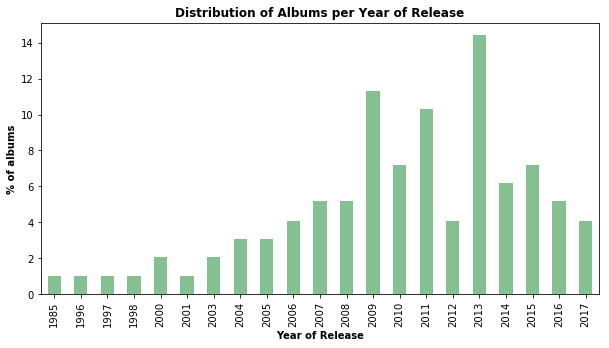

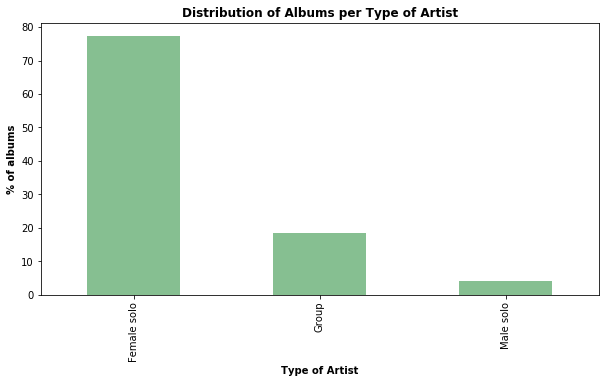

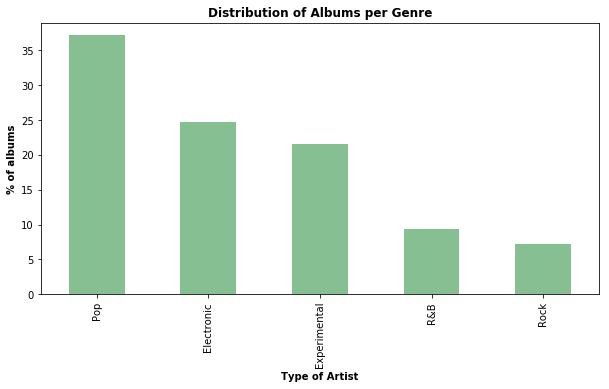

In [84]:
## VISUALIZATION OF ALBUM RELATIVE FREQUENCY PER YEAR, TYPE OF ARTIST, GENRE, AND LENGTH 

## BAR PLOTS: YEAR, TYPE OF ARTIST, GENRE

# Count the total number of albums
album_total = len(data['album_name'])

# Percentage of albums count per each category
per_year = data.groupby('year')[["album_name"]].count().divide(album_total).multiply(100).round(decimals = 1)
per_type = data.groupby('type')[["album_name"]].count().divide(album_total).multiply(100).round(decimals = 1)
per_genre = data.groupby('genre')[["album_name"]].count().divide(album_total).multiply(100).round(decimals = 1).sort_values('album_name', ascending = False)

# Plot the distribution per year
figure_albums_per_year = per_year.plot.bar(figsize = (10,5), legend = False, color='#86bf91')
figure_albums_per_year.set_title("Distribution of Albums per Year of Release", weight = 'bold')
figure_albums_per_year.set_xlabel("Year of Release", weight = 'bold')
figure_albums_per_year.set_ylabel("% of albums", weight = 'bold')

# Plot the distribution per type of artist
figure_albums_per_type = per_type.plot.bar(figsize = (10,5), legend = False, color='#86bf91')
figure_albums_per_type.set_title("Distribution of Albums per Type of Artist", weight = 'bold')
figure_albums_per_type.set_xlabel("Type of Artist", weight = 'bold')
figure_albums_per_type.set_ylabel("% of albums", weight = 'bold')

# Plot the distribution per type of artist
figure_albums_per_genre = per_genre.plot.bar(figsize = (10,5), legend = False, color='#86bf91')
figure_albums_per_genre.set_title("Distribution of Albums per Genre", weight = 'bold')
figure_albums_per_genre.set_xlabel("Type of Artist", weight = 'bold')
figure_albums_per_genre.set_ylabel("% of albums", weight = 'bold')

As seen above, 35% of albums in my playlist have been released in years 2009, 2011, and 2013. Interestingly, though not surprisingly given my pop- and dance music-oriented ear, almost 80% of albums in this dataset have been released by solo female artists. More than 70% of albums belong to pop, electronic, and experimental genres. 

I then plotted the distribution of albums per length and album score so that I could perform some basic inferential statistics. 

Text(0,0.5,'% of albums')

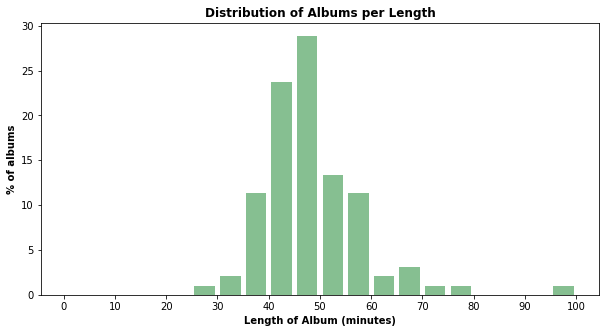

In [85]:
## HISTOGRAM PLOT: LENGTH OF ALBUM

fig1, ax1 = plt.subplots(figsize = (10,5))
ax1.hist(data.length, weights = np.zeros_like(data.length) + 100*(1./ data.length.size), bins = 20, range = (0,100), rwidth  = 0.8, color='#86bf91')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.yticks([0, 5, 10, 15, 20, 25, 30])
ax1.set_title("Distribution of Albums per Length", weight = 'bold')
ax1.set_xlabel("Length of Album (minutes)", weight = 'bold')
ax1.set_ylabel("% of albums", weight = 'bold')

Text(0,0.5,'% of albums')

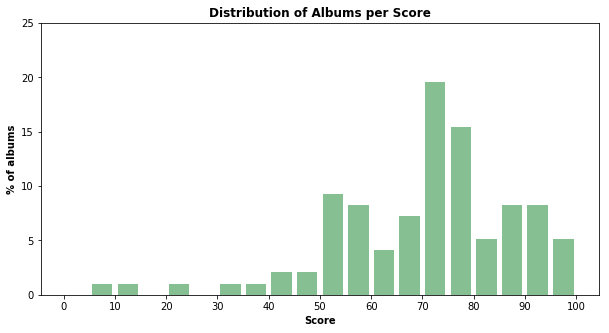

In [86]:
## HISTOGRAM PLOT: ALBUM SCORES

fig2, ax2 = plt.subplots(figsize = (10,5))
ax2.hist(data.my_score, weights = np.zeros_like(data.my_score) + 100*(1./ data.my_score.size), bins = 20, range = (0,100), rwidth  = 0.8, color='#86bf91')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.yticks([0, 5, 10, 15, 20, 25])
ax2.set_title("Distribution of Albums per Score", weight = 'bold')
ax2.set_xlabel("Score", weight = 'bold')
ax2.set_ylabel("% of albums", weight = 'bold')

If we assume these 97 albums represent my future listening profile, we can treat these datapoints as a statistically representative sample of an entire population of albums, including current and future ones. As such, I wanted to calculate the mean length and score of albums in my collection, along with 95% confidence intervals. Given that I don't really know the variance of the entire population, I opted for t-statistic in this case. So, before any calculations, I first defined functions for calculating sample standard deviations and t-based confidence intervals. 

In [87]:
# SAMPLE STANDARD DEVIATION FUNCTION

def sample_std(series):
    """
    The function returns the standard deviation of the sample based on the formula:
    s = sqrt(s2) where s2 is sample variance WHERE
    s2 = sum(data_point - sample_mean)^2 / (n-1)
    
    INPUT:
    
    series: data series on which to calculate sample standard deviation
    
    OUTPUT:
    
    sample_std: sample standard deviation
    """
    sample_std = np.sqrt(np.sum(np.power(series - series.mean(),2)) / (series.size-1))
    return sample_std

# INTERVAL / MARGINAL ERROR FUNCTION 

def marginal_error(series, alpha, sample_std):
    """
    This function returns the marginal error in the confidence interval based on the formula:
    interval = t*standard_error WHERE
    standard_error = sample_std / sqrt(sample_size) AND WHERE
    t-statistic is calculated through the ppf method with (1 - alfa/2) signifying the portions of tails to cut.
    
    INPUT:
    
    series: data series on which to calculate the interval
    alpha: confidence level (usually 0.1, 0.05, 0.01)
    sample_std: sample standard deviation calculated through the sample_std function.
    
    OUTPUT:
    
    marginal_error: range of the interval expressed as the marginal error
    """
    marginal_error = t.ppf(1.0 - (alpha / 2.0), series.size-1) * (sample_std / np.sqrt(series.size))
    return round(marginal_error,1)

# MEAN POINT ESTIMATE AND ITS CONFIDENCE INTERVAL

def confidence_interval(mean, marginal_error):
    """
    This function returns a tuple that contains:
    (lower end of the confidence interval, the mean, upper end of the confidence interval) at the desired confidence level. 
    
    INPUT:
    
    mean: mean point estimate of the data series
    marginal_error: marginal error calculated through the marginal_error function
    
    OUTPUT:
    
    CI: tuple that contains the point estimate as well as the lower- and upper-limit of the interval.
    """
    CI = (mean - marginal_error, mean, mean + marginal_error)
    return CI

In [88]:
# MEAN POINT ESTIMATE OF LENGTH 

mean_length = round(np.mean(data.length),1)

# 95% CONFIDENCE INTERVAL

confidence_interval(mean_length, marginal_error(data.length, 0.05, sample_std(data.length)))

(46.4, 48.4, 50.4)

In [89]:
# MEAN POINT ESTIMATE OF SCORE

mean_score = round(np.mean(data.my_score),1)

# 95% CONFIDENCE INTERVAL

confidence_interval(mean_score, marginal_error(data.my_score, 0.05, sample_std(data.my_score)))

(66.0, 69.7, 73.4)

These numbers indicate we can be 95% confident that the true population mean of all albums, current and future ones, will fall within the following ranges:

* (1) For length, the true population mean will be between 46.4 and 50.4 minutes. 
* (2) For score, the true population mean will be between 66.0 and 73.4. 

Broken down in less technical lingo, if we assume my taste in music doesn't notably change, albums that secure a permanent spot on my playlist will be, on average, of typical LP length (40 - 50 minutes) and, on average, will *not* be outstanding albums given the score bracket of 65 - 75. 

Although this makes sense, I still found the latter conclusion surprising. It signals that many of the albums that I regularly listen to contain songs that have not grown on me. This means, furthermore, that I consider a notable chunk of my favorite albums to be "very good" or only "good" according to this scoring methodology.

# Comparison to Music Publications

Before I looked at the correlation between my scores and those of other music publications, it was important to notice that musicOMH, The Guardian, and AllMusic assign scores on a scale from 0 to 5 in increments of 0.5, which translates to multiples of 10 on a 0 to 100 scale. Meanwhile, Pitchfork assigns scores on a scale from 0 to 10 in increments of 0.1, while Metacritic assigns scores on a scale from 0 to 100 in increments of 1.

These discrepancies can be clearly seen in the distribution histogram plots below.

Text(0.5,1,'All Music Scores')

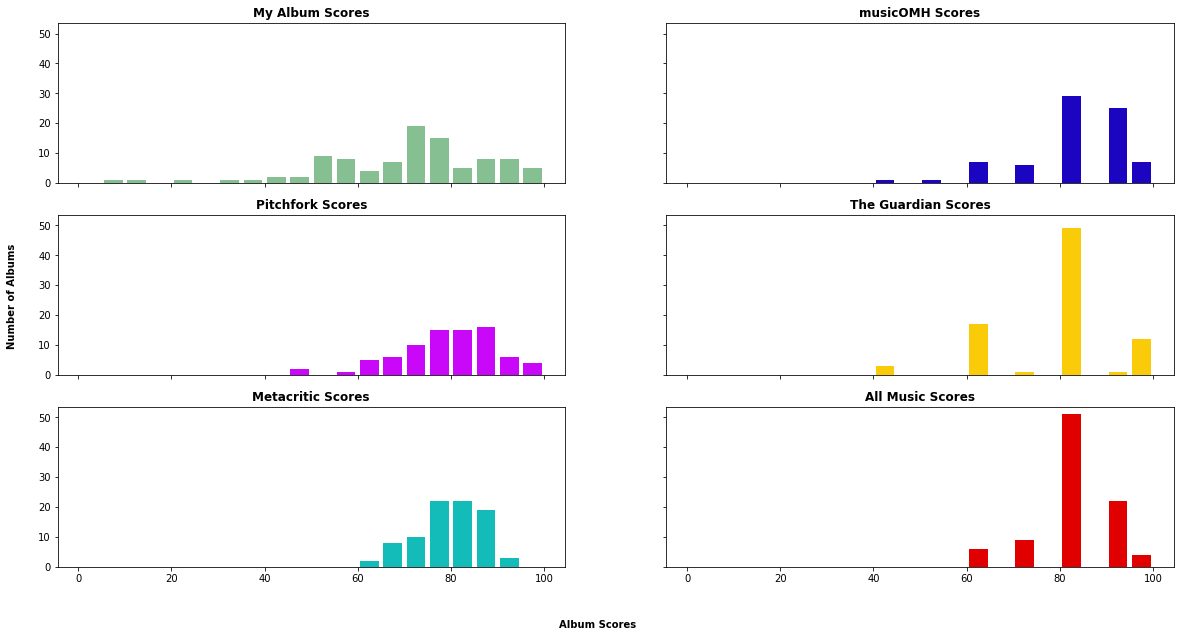

In [90]:
## HISTOGRAM SUBPLOTS OF ALBUM SCORE DISTRIBUTIONS 

fig,((ax1, ax2), (ax3, ax4), (ax5, ax6))= plt.subplots(3, 2, sharex = True, sharey = True, figsize = (20,10))
fig.text(0.5, 0.04, 'Album Scores', ha='center', weight = 'bold')
fig.text(0.09, 0.5, 'Number of Albums', va='center', rotation='vertical', weight = 'bold')

# My Scores
ax1.hist(data.my_score, bins = 20, range = (0,100), color='#86bf91', rwidth=0.8)
ax1.set_title("My Album Scores", weight = 'bold')

# MusicOMH Scores
ax2.hist(data.musicOMH_score, bins = 20, range = (0,100), color='#1B05C1', rwidth=0.8)
ax2.set_title("musicOMH Scores", weight = 'bold')

# Pitchfork Scores    
ax3.hist(data.pitchfork_score, bins = 20, range = (0,100), color='#CA08F9', rwidth=0.8)
ax3.set_title("Pitchfork Scores", weight = 'bold')

# The Guardian Scores
ax4.hist(data.theguardian_score, bins = 20, range = (0,100), color='#F9CB08', rwidth=0.8)
ax4.set_title("The Guardian Scores", weight = 'bold')

# Metacritic Scores
ax5.hist(data.metacritic_score, bins = 20, range = (0,100), color='#13BCB8', rwidth=0.8)
ax5.set_title("Metacritic Scores",weight = 'bold')

# All Music Scores
ax6.hist(data.allmusic_score, bins = 20, range = (0,100), color='#E00000', rwidth=0.8)
ax6.set_title("All Music Scores", weight = 'bold')

Looking at these plots, we can see that other publications' scores tend to skew higher compared to mine. The frequency distribution of my scores, however, also has a long left tail. In general, one can notice that the albums in the dataset have good (60+) scores — an expected finding if we assume that:
* Albums that I listen repeatedly tend to be those that I like and therefore have higher scores, and that
* Music journalists will, on average, agree on the overall quality of these albums, therefore also assigning higher scores. 

This was further corroborated by the mean scores and sample standard deviations, which show that my distribution of album scores has the lowest mean and the largest standard deviation. MusicOMH's distribution, on the other hand, has the highest mean, while Metacritic has the lowest sample standard deviation. The latter, in particular, was expected since Metacritic is an aggregator website. 

As a side note, for simplicity and relevance, I did not calculate confidence intervals for the album scores of music publications.

In [121]:
## DESCRIPTIVE STATISTICS OF ALBUM SCORE DISTRIBUTIONS 

# Means and standard deviations

means = data[['allmusic_score', 'musicOMH_score', 'theguardian_score', 'pitchfork_score', 'metacritic_score']].mean().round(decimals = 1)
stdevs = data[['allmusic_score', 'musicOMH_score', 'theguardian_score', 'pitchfork_score', 'metacritic_score']].apply(lambda x: sample_std(x)).round(decimals = 1)

C:\Users\Denis Bozic\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power


In [92]:
means

allmusic_score       81.0
musicOMH_score       81.6
theguardian_score    77.3
pitchfork_score      78.4
metacritic_score     79.1
dtype: float64

In [93]:
stdevs

allmusic_score        8.5
musicOMH_score       10.7
theguardian_score    12.9
pitchfork_score       9.4
metacritic_score      6.5
dtype: float64

Going back to the comparison of scoring methodologies, I first rounded my scores to the nearest multiple of 10 when comparing data to musicOMH, The Guardian, and AllMusic. So, for example, Grimes' *Art Angels* album, which had a score of 86, got rounded to 90. The data remained untransformed for comparisons against Pitchfork and Metacritic, since their scores had the same scale as mine. 

Text(0.5,1,'AllMusic')

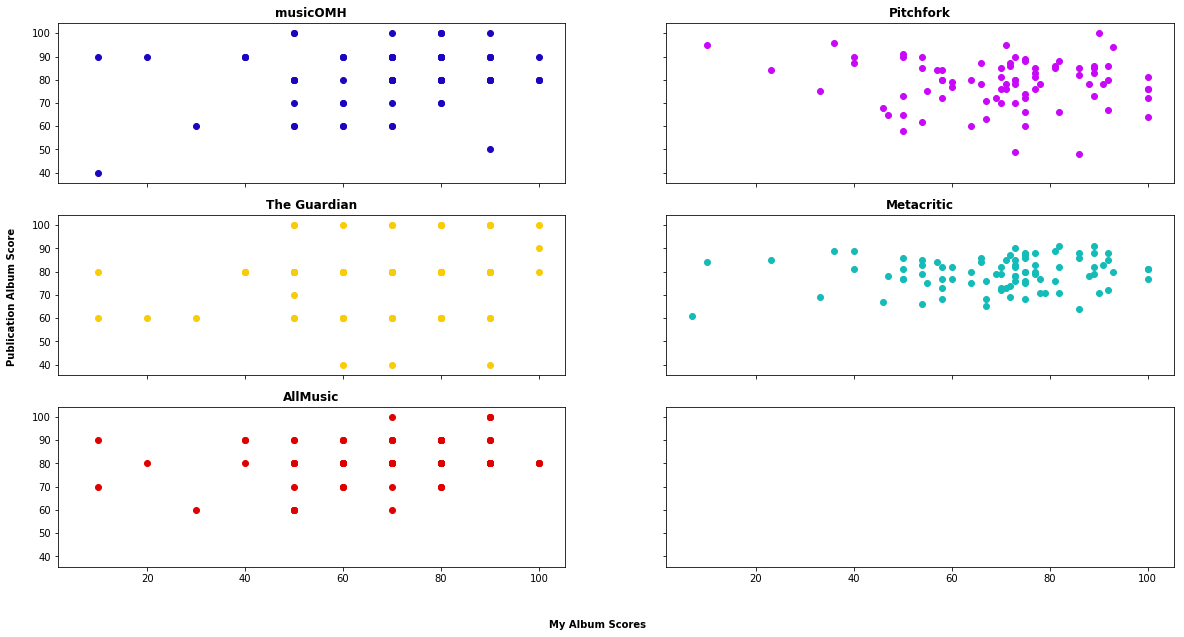

In [94]:
## CORRELATION OF MY SCORES WITH OTHER PUBLICATIONS

# SCATTER SUBPLOTS OF ALBUM SCORE DISTRIBUTIONS 

fig,((ax1, ax2), (ax3, ax4), (ax5, ax6))= plt.subplots(3, 2, sharex = True, sharey = True, figsize = (20,10))
fig.text(0.5, 0.04, 'My Album Scores', ha='center', weight = 'bold')
fig.text(0.09, 0.5, 'Publication Album Score', va='center', rotation='vertical', weight = 'bold')

# Music OMH Scores
ax1.scatter(data.my_score.round(-1), data.musicOMH_score, color='#1B05C1')
ax1.set_title("musicOMH", weight = 'bold')

# Pitchfork Scores    
ax2.scatter(data.my_score, data.pitchfork_score, color='#CA08F9')
ax2.set_title("Pitchfork", weight = 'bold')

# The Guardian Scores
ax3.scatter(data.my_score.round(-1), data.theguardian_score, color='#F9CB08')
ax3.set_title("The Guardian", weight = 'bold')

# Metacritic Scores
ax4.scatter(data.my_score, data.metacritic_score, color='#13BCB8')
ax4.set_title("Metacritic", weight = 'bold')

# AllMusic Scores
ax5.scatter(data.my_score.round(-1), data.allmusic_score, color='#E00000')
ax5.set_title("AllMusic",weight = 'bold')


I then ran the correlation analysis for these scores. 

In [95]:
# Correlation analysis

correlation_OMH = data['my_score'].round(-1).corr(data['musicOMH_score'])
correlation_pitchfork = data['my_score'].corr(data['pitchfork_score'])
correlation_theguardian = data['my_score'].round(-1).corr(data['theguardian_score'])
correlation_metacritic = data['my_score'].corr(data['metacritic_score'])
correlation_allmusic = data['my_score'].round(-1).corr(data['allmusic_score'])

In [96]:
# Correlation coefficients

coefficients_raw = [correlation_OMH, correlation_pitchfork, correlation_theguardian, correlation_metacritic, correlation_allmusic]
np.around(np.array(coefficients_raw),2)

array([ 0.21, -0.09,  0.19,  0.14,  0.26])

I expected to see a somewhat stronger linear correlation between these scores, but overall, my album scores were weakly correlated with those of other music publications. Highest coefficients corresponded to correlations with AllMusic, musicOMH, and TheGuardian, for which my scores had to be transformed to nearest multiple of 10. Had the data not been transformed, these coefficients would have been slightly lower. Generally, I was most surprised by the near-zero correlation coefficient with Pitchfork scores, indicating no linear relationship between our album scores. I considered transforming some of these variables (for example, into a logarithmic scale), but I didn't see any solid theoretical ground to assume a non-linear relationship between these independent variables.  

# Regression Models

I then wanted to see whether my album score was, to some extent, influenced by length of the album, type of artist, genre, and year of release. Albeit a notably simplified representation of reality, I was interested in seeing whether regression models could explain my taste in music.  

Before doing any calculations, I wanted to define a function that would get rid of outliers based on sample standard deviation in case such operation was necessary. My reasoning here was that outliers in my scores were albums that I really didn't like (as a fun fact, those were Lady Gaga's *Artpop*, Kanye West's *Yeezus*, and The Knife's *Shaking the Habitual*). As these scores would negatively impact the regression models, I wanted to delete them. Additionally, since I didn't need scores of music publications for this analysis, I shortened the dataframe only to essential columns.

In [97]:
# Reducing data only to necessary columns

data_reduced = data[['artist_name', 'album_name', 'my_score', 'year', 'length', 'type', 'female', 
            'genre', 'pop', 'electronic', 'experimental', 'rock',]]

In [98]:
def remove_outliers(data, series):   
    """
    This function removes outliers in the series
    by deleting all points outside 2 sigma from the mean.
    
    INPUTS
    
    series: series based on which outliers will be removed
    
    OUTPUTS
    
    series_filtered: new dataframe with removed outliers across all series
    """
    mean = np.mean(series)
    stdev = np.std(series)
    data_filtered = data[(series > mean - 2*stdev) & (series < mean + 2*stdev)]
    return data_filtered

In [99]:
# Removing the outliers using the remove_outliers function

data_filtered = remove_outliers(data_reduced, data_reduced.my_score)

In [100]:
data_filtered.head()

,artist_name,album_name,my_score,year,length,type,female,genre,pop,electronic,experimental,rock
0,Adele,19,58,2008,43.68,Female solo,1,Pop,1,0,0,0
1,Adele,21,73,2011,48.20,Female solo,1,Pop,1,0,0,0
2,AlunaGeorge,Body Music,71,2013,50.37,Group,0,Pop,1,0,0,0
3,Amy Winehouse,Frank,73,2007,58.80,Female solo,1,R&B,0,0,0,0
4,Amy Winehouse,Back to Black,100,2006,34.93,Female solo,1,Pop,1,0,0,0


**Linear Regression Model**

As with every linear regression model, I wanted to check for the following criteria before fitting the data:

* (1) Linearity
* (2) No endogeneity of regressors
* (3) Normality and homoescadasticity 
* (4) No autocorrelation
* (5) No multicollinearity 

 **Linearity**
 
Since genre and type of artist were categorical data that would be assigned dummy variables, I wanted to check only linearity for year of release and length of album. 

Text(0.5,1,'Year of Release')

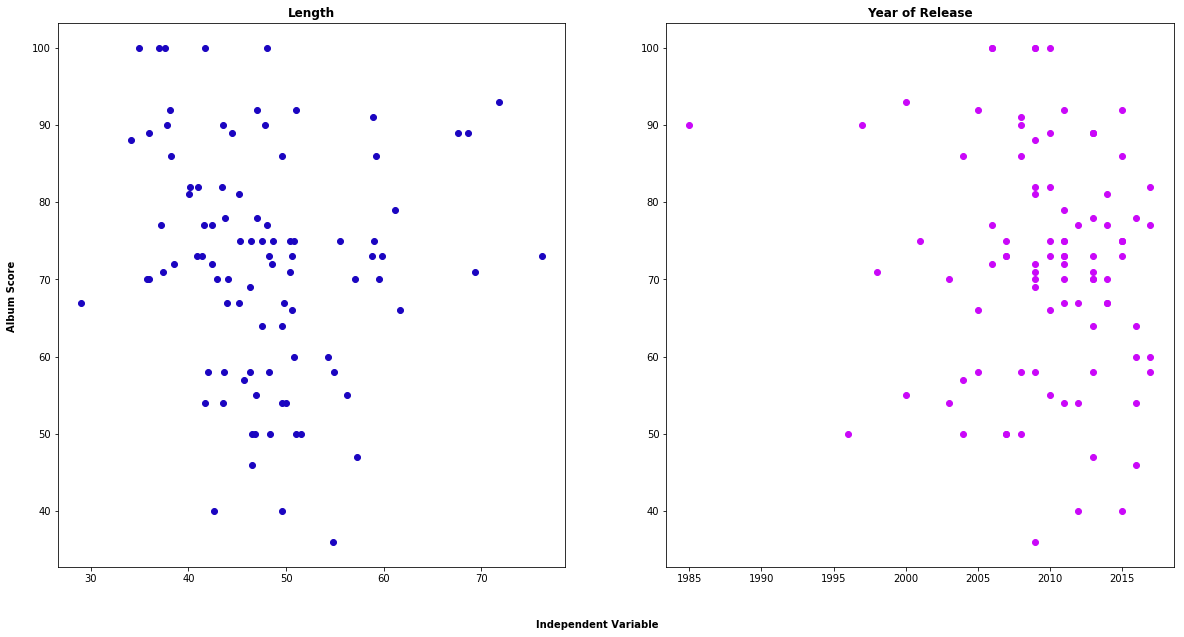

In [101]:
## LINEARITY CHECK

# SCATTER SUBPLOTS OF ALBUM SCORE DISTRIBUTIONS 

fig,(ax_left, ax_right)= plt.subplots(1, 2, sharex = False, sharey = False, figsize = (20,10))
fig.text(0.5, 0.04, 'Independent Variable', ha='center', weight = 'bold')
fig.text(0.09, 0.5, 'Album Score', va='center', rotation='vertical', weight = 'bold')

# Length of the album
ax_left.scatter(data_filtered.length, data_filtered.my_score, color='#1B05C1')
ax_left.set_title("Length", weight = 'bold')

# Year of Release    
ax_right.scatter(data_filtered.year, data_filtered.my_score, color='#CA08F9')
ax_right.set_title("Year of Release", weight = 'bold')

As can be seen, for these two variables, linearity is not observed, and the relationship is rather random. Even after transforming the independent and dependent variables to log and square root distributions, the visual lack of linear relationship persisted. This obviously served as a detriment for the model, but I still wanted to see whether the other variables, type of artists and genre, could be used to have statistical significance in explaining some variability in the score distribution.

With only categorical variables left in the explanation of variability in album scores, I assumed no endogeneity of regressors ad normality and homoescadasticity of error term. Since this is not time-series data, I also assumed no autocorrelation. However, I wanted to check whether there was any significant correlation between each of the genre variables and type of artist. 

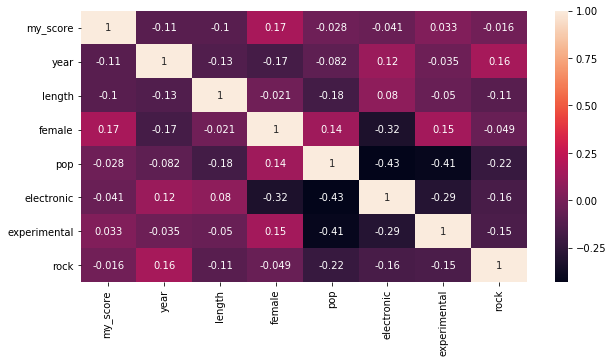

In [102]:
# Plotting the heatmap of correlations across all variables

fig1, ax1 = plt.subplots(figsize = (10,5))
sns.heatmap(data_filtered.corr(), annot=True)

We can notice from this heatmap that genres and type of artist are weakly correlated, with values less than absolute 0.5, which means that it's valid to include them in the model. 

In [103]:
# LINEAR REGRESSION ON TYPE OF ARTIST AND GENRE

# Defining the X and Y variables
X = data_filtered[['female', 'pop', 'electronic', 'experimental', 'rock']]
y = data_filtered['my_score']

# Anova Analysis
X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
anova = model.summary()

In [104]:
anova

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               my_score   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.5853
Date:                Tue, 13 Nov 2018   Prob (F-statistic):              0.711
Time:                        23:52:22   Log-Likelihood:                -381.14
No. Observations:                  93   AIC:                             774.3
Df Residuals:                      87   BIC:                             789.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           69.8285      6.179     11.300      0.000      57.546      82.111
female           6.0679      4.048      1.499      0.138      -1.979      14.114
pop             -3.6010      5.634     -0.639      0.524     -14.799       7.597
electronic      -2.2747      6.123     -0.371      0.711     -14.445       9.896
experimental    -2.3896      6.049     -0.395      0.694     -14.413       9.634
rock            -3.0199      7.628     -0.396      0.693     -18.181      12.141
==============================================================================
Omnibus:                        2.779   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                2.582
Skew:                          -0.328   Prob(JB):                        0.275
Kurtosis:                       2.516   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at the p-values and the F-statistic, it's clear that the overall model, along with the independent variables, is not a statistically significant fit. As such, linear regression as a model cannot be used to explain variability in my album scores.

**Logistic Regression Model**

While linear regression can't be implemented to explain variability in my album scores, I thought the target variable could be transformed to a binary outcome that would represent whether I perceive the album as 'good' or 'not good'. Although somewhat subjective, I picked the mean album score as the cut-off: any album above the score of 70 is considered 'good' any album below 70 is considered 'not good'. I did this to implement a logistic regression model. Before doing so, it was necessary to define a function that could transform the target variable.

In [105]:
# Defining the function:

def turn_to_dummy(data, columns, reference):
    """This function inspects each
    element of a column to see if equal 
    to reference. Transforms to 1 or 0.
    """
    for column in columns:
        data.update(data[column].apply(lambda x: 1 if x > reference else 0))
    return data

In [106]:
# Defining the columns to be transformed

columns = ['my_score']

# Calling the function on my_score column

transformed_data = turn_to_dummy(data_filtered, columns, 70)

In [107]:
transformed_data.head()

,artist_name,album_name,my_score,year,length,type,female,genre,pop,electronic,experimental,rock
0,Adele,19,0,2008,43.68,Female solo,1,Pop,1,0,0,0
1,Adele,21,1,2011,48.20,Female solo,1,Pop,1,0,0,0
2,AlunaGeorge,Body Music,1,2013,50.37,Group,0,Pop,1,0,0,0
3,Amy Winehouse,Frank,1,2007,58.80,Female solo,1,R&B,0,0,0,0
4,Amy Winehouse,Back to Black,1,2006,34.93,Female solo,1,Pop,1,0,0,0


In [108]:
# Let's see how many albums we have in each category.

transformed_data.groupby('my_score').album_name.count()

my_score
0    39
1    54
Name: album_name, dtype: int64

Text(72.625,0.5,'Number of Albums')

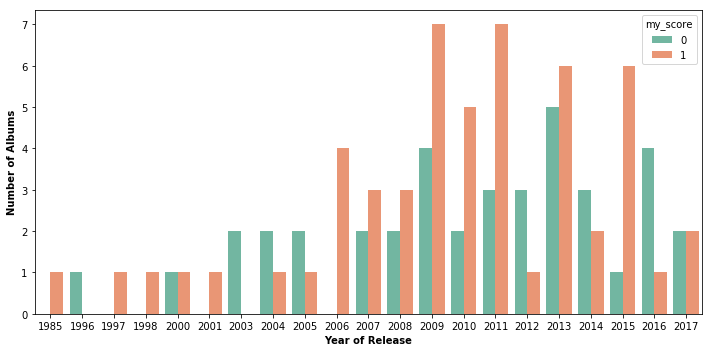

In [109]:
# Let's see how they differ for year of release. 

plt.figure(figsize=(10,5))
sns.countplot(x='year', hue='my_score', data=transformed_data, palette='Set2')
plt.tight_layout()
plt.xlabel('Year of Release', weight = 'bold')
plt.ylabel('Number of Albums', weight = 'bold')

There seems to be some difference across year of release, so makes sense to include this variable in the logistic regression model. 

Text(66.375,0.5,'Number of Albums')

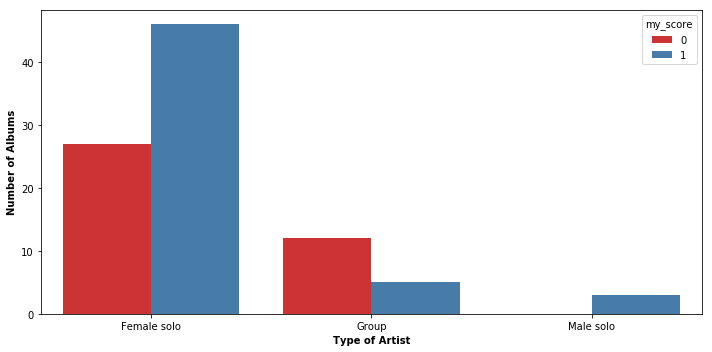

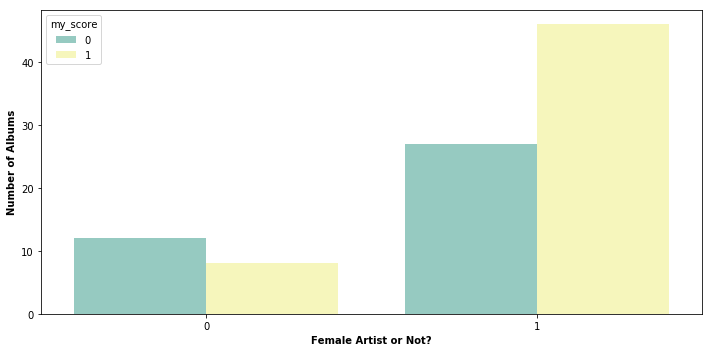

In [110]:
# Let's see how they differ for type of artist: female or not.

# Artist type - variable categorical

plt.figure(figsize=(10,5))
sns.countplot(x='type', hue='my_score', data=transformed_data, palette='Set1')
plt.tight_layout()
plt.xlabel('Type of Artist', weight = 'bold')
plt.ylabel('Number of Albums', weight = 'bold')

# Artist type - dummy variable as female artist as reference

plt.figure(figsize=(10,5))
sns.countplot(x='female', hue='my_score', data=transformed_data, palette='Set3')
plt.tight_layout()
plt.xlabel('Female Artist or Not?', weight = 'bold')
plt.ylabel('Number of Albums', weight = 'bold')

This category certainly seems to be an influence once we break it down into a dummy variable, with 0 being non-female artists and 1 being female artists. We will include it in the model. 

Text(56.625,0.5,'Number of Albums')

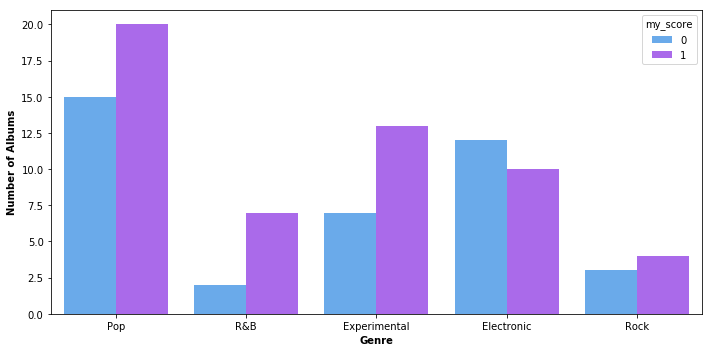

In [111]:
# Let's check how they differ per type of music

plt.figure(figsize=(10,5))
sns.countplot(x='genre', hue='my_score', data=transformed_data, palette='cool')
plt.tight_layout()
plt.xlabel('Genre', weight = 'bold')
plt.ylabel('Number of Albums', weight = 'bold')

We can definitely see a difference across *certain* genres, which is also impacted by the uneven sample sizes across these categories. For now, let's include the variable in the model. 

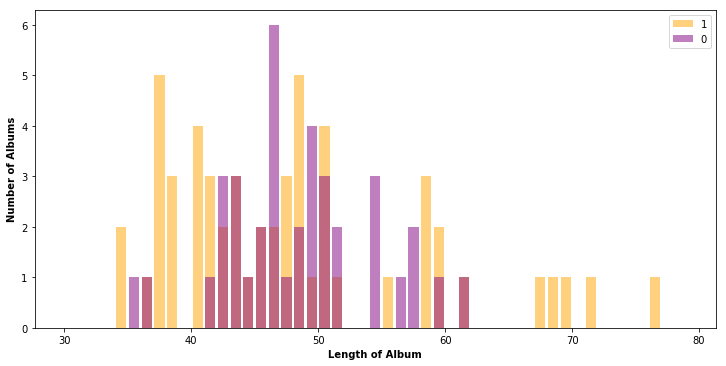

In [112]:
# Now, let's see whether there is a specific difference across the album length. 

plt.figure(figsize=(10,5))
bins = np.arange(30, 80)
data_filtered[data_filtered['my_score']==1]['length'].hist(alpha=0.5, color='orange', bins=bins, label='1', rwidth = 0.8)
data_filtered[data_filtered['my_score']==0]['length'].hist(alpha=0.5, color='purple', bins=bins, label='0', rwidth = 0.8)
plt.legend()
plt.tight_layout()
plt.xlabel('Length of Album', weight = 'bold')
plt.ylabel('Number of Albums', weight = 'bold')
plt.grid(False)

We can also see a difference across length of the album. For now, we will include this variable in the model. 

In [113]:
# LOGISTIC REGRESSION MODEL

# Defining the X and Y variables
X = transformed_data[['year', 'length', 'female', 'pop', 'electronic', 'experimental', 'rock']]
y = transformed_data['my_score']

# Anova Analysis
X = sm.add_constant(X, prepend=False) # adding a constant
logit_models = sm.Logit(y, X)
report = logit_models.fit()

Optimization terminated successfully.
         Current function value: 0.650199
         Iterations 5


In [114]:
print(report.summary2())

                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.044   
Dependent Variable: my_score         AIC:              136.9370
Date:               2018-11-13 23:52 BIC:              157.1978
No. Observations:   93               Log-Likelihood:   -60.469 
Df Model:           7                LL-Null:          -63.248 
Df Residuals:       85               LLR p-value:      0.59215 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|    [0.025   0.975] 
---------------------------------------------------------------
year         -0.0102   0.0430 -0.2378 0.8121   -0.0946   0.0741
length       -0.0076   0.0277 -0.2754 0.7830   -0.0620   0.0467
female        0.7638   0.5553  1.3755 0.1690   -0.3246   1.8521
pop          -1.0195   0.9255 -1.1016 0.2706   -2.8335   0.7945
e

Once again, we see that the variables are not statistically significant, even for the logistic regression model after transforming the target variable. We can also look at logistic regression as a machine learning algorithm. 

In [115]:
# Defining the training and testing split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [116]:
# Calling the Log-R function

logmodel = LogisticRegression()

In [117]:
# Fitting the training data

logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [118]:
# Predicting the data from the X test-set. 

y_predict = logmodel.predict(X_test)

In [119]:
# Importing the classification report. 

from sklearn.metrics import classification_report

In [120]:
# Calling the classification report.

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.27      0.38      0.32         8
           1       0.71      0.60      0.65        20

   micro avg       0.54      0.54      0.54        28
   macro avg       0.49      0.49      0.48        28
weighted avg       0.58      0.54      0.55        28



Interestingly, precision and recall tend to do better for the '1' class. This is likely a result of having more 'good' albums in this dataset. The ultimate conclusion is that I would need notably more data points to make these models statistically significant. This will hopefully happen after many more years of listening to music. 

# Final thoughts

What were some findings from this — admittedly simplified — analysis? 
* (1) That my methodology of scoring albums leads to generally lower scores compared to eminent music publications,
* (2) That my scores are weakly correlated with scores of those music publications, and that 
* (3) The linear and logistic regression models cannot be used to explain variability in my album scores as there is yet no statistical significance.   

Looking onward, as part of my next project, the analysis can be *potentially* improved by expanding the dataset and including additional variables, of which the most insightful would be the quality of lyrical content, the quality of production, and the quality of musical and vocal arrangements. These variables could also be scored on a scale from 1 to 100. The best improvement, however, will be made after many more years of listening to music. 